In [3]:
import numpy as np
import h5py
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

PREPROCESSED_DATA_DIR = Path(
    '/media/netanel/Backup/Image Processing Course Project/data/preprocessed')

In [95]:
with h5py.File(PREPROCESSED_DATA_DIR / 'videos.h5') as f:
    frames = np.array(f['P1LC6'][:10])
frames.shape

(10, 350, 450, 3)

In [117]:
9019 / 5

1803.8

In [98]:
sample = frames[:10]

In [99]:
converted_frames = []
for frame in sample:
    converted_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2YCrCb)
    converted_frames.append(converted_frame.copy())
converted_frames = np.array(converted_frames)    

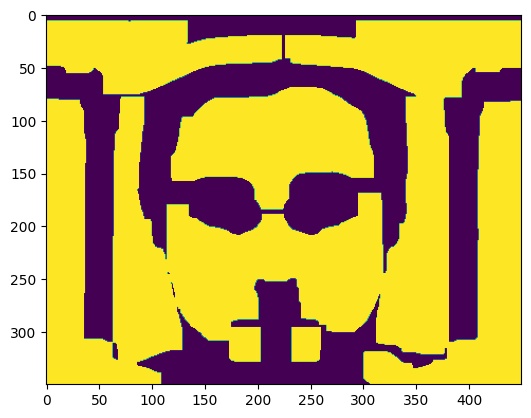

In [116]:
plt.imshow(cv2.dilate(cv2.erode(cv2.threshold(cv2.GaussianBlur(sample[0, ..., 0], (5, 5), 0), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1], None, iterations=10), None, iterations=10))

In [38]:
from skimage.measure import regionprops, label

In [39]:
rps = regionprops(label(cv2.inRange(converted_frames[0], np.array(
    [0, 133, 77]), np.array([255, 173, 127]))))

In [40]:
[r.area for r in rps]

[4.0,
 50720.0,
 12.0,
 4.0,
 264.0,
 24.0,
 40.0,
 16.0,
 40.0,
 28.0,
 36.0,
 112.0,
 952.0,
 4.0,
 4.0,
 1256.0]

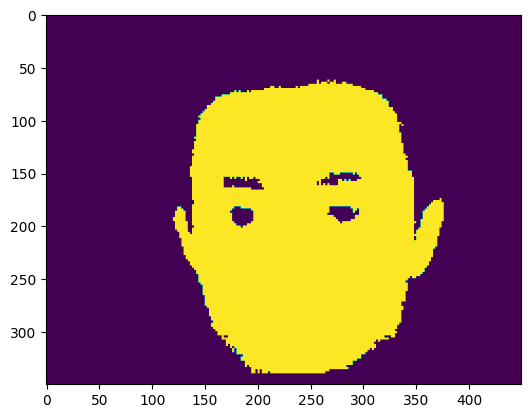

In [58]:
coords = rps[np.argmax([r.area for r in rps])].coords.T
skin = np.zeros_like(converted_frames[0][..., 0])
skin[tuple(coords)] = 1
plt.imshow(skin)

In [60]:
skin.min(), skin.max(), np.unique(skin)

(0, 1, array([0, 1], dtype=uint8))

Watershed method

https://github.com/Jeanvit/PySkinDetection/blob/master/src/skinDetector.py

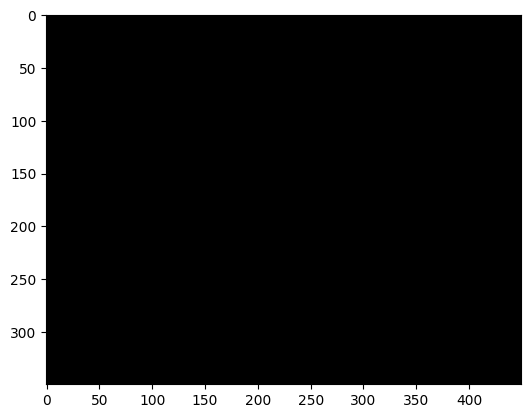

In [73]:
image_foreground = cv2.erode(skin, None, iterations=3)  # remove noise

# The background region is reduced a little because of the dilate operation
dilated_binary_image = cv2.dilate(skin, None, iterations=3)
# set all background regions to 128
_, image_background = cv2.threshold(dilated_binary_image, 1, 128, cv2.THRESH_BINARY)

# add both foreground and background, forming markers. The markers are "seeds" of the future image regions.
image_marker = cv2.add(image_foreground, image_background)
image_marker32 = np.int32(image_marker)  # convert to 32SC1 format

image_marker32 = cv2.watershed(frames[0], image_marker32)
m = cv2.convertScaleAbs(image_marker32)  # convert back to uint8

# bitwise of the mask with the input image
_, img = cv2.threshold(m, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
res = cv2.bitwise_and(frames[0], np.zeros_like(frames), mask=img)

plt.imshow(res)

In [80]:
from enum import Enum, auto
import cv2
import numpy as np


class Method(Enum):
	'''Available methods for processing an image
			REGION_BASED: segment the skin using the HSV and YCbCr colorspaces, followed by the Watershed algorithm'''
	REGION_BASED = auto()


class SkinDetector():

	def __init__(self, frame) -> None:
		self.image = frame
		self.image_mask = None
		self.skin = None

	def find_skin(self, method=Method.REGION_BASED) -> None:
		'''function to process the image based on some method '''
		if (method == Method.REGION_BASED):
			self.__color_segmentation()
			self.__region_based_segmentation()

	def get_resulting_images(self) -> tuple:
		"""Returns the processed images
				[0] = The original image
				[1] = The resulting image mask containing the skin
				[2] = The result image after a bitwise_and of [1] and [0]"""

		return self.image, self.image_mask, self.skin

	def __color_segmentation(self) -> None:
		'''Apply a threshold to an HSV and YCbCr images, the used values were based on current research papers along with some empirical tests and visual evaluation'''

		HSV_image = cv2.cvtColor(self.image, cv2.COLOR_BGR2HSV)
		YCbCr_image = cv2.cvtColor(self.image, cv2.COLOR_BGR2YCR_CB)

		lower_HSV_values = np.array([0, 40, 0], dtype="uint8")
		upper_HSV_values = np.array([25, 255, 255], dtype="uint8")

		lower_YCbCr_values = np.array((0, 138, 67), dtype="uint8")
		upper_YCbCr_values = np.array((255, 173, 133), dtype="uint8")

		# A binary mask is returned. White pixels (255) represent pixels that fall into the upper/lower.
		mask_YCbCr = cv2.inRange(YCbCr_image, lower_YCbCr_values, upper_YCbCr_values)
		mask_HSV = cv2.inRange(HSV_image, lower_HSV_values, upper_HSV_values)

		self.skin_mask = cv2.add(mask_HSV, mask_YCbCr)

	def __region_based_segmentation(self) -> None:
		'''Function that applies Watershed and morphological operations on the thresholded image morphological operations'''

		image_foreground = cv2.erode(
			self.skin_mask, None, iterations=3)  # remove noise

		# The background region is reduced a little because of the dilate operation
		dilated_binary_image = cv2.dilate(self.skin_mask, None, iterations=3)
		# set all background regions to 128
		_, image_background = cv2.threshold(
			dilated_binary_image, 1, 128, cv2.THRESH_BINARY)

		# add both foreground and background, forming markers. The markers are "seeds" of the future image regions.
		image_marker = cv2.add(image_foreground, image_background)
		image_marker32 = np.int32(image_marker)  # convert to 32SC1 format

		image_marker32 = cv2.watershed(self.image, image_marker32)
		m = cv2.convertScaleAbs(image_marker32)  # convert back to uint8

		# bitwise of the mask with the input image
		_, self.image_mask = cv2.threshold(
			m, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
		self.skin = cv2.bitwise_and(self.image, self.image, mask=self.image_mask)

	def show_all_images(self, window_title="Original Image | Skin Mask | Result") -> None:
		'''Show all processed images concatenated along the 1 axis using imshow '''
		rgb_mask = cv2.cvtColor(self.image_mask, cv2.COLOR_GRAY2RGB)
		plt.imshow(np.concatenate(
			(self.image, rgb_mask, self.skin), axis=1))

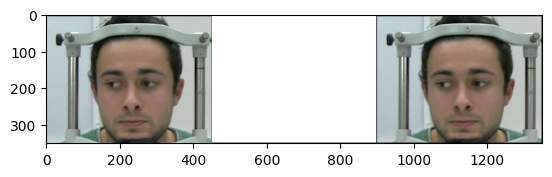

In [81]:
detector = SkinDetector(frame=frames[0])
detector.find_skin()
detector.show_all_images()